In [1]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# importing MNIST dataset
mnist = fetch_openml('mnist_784')
X, y = mnist["data"], mnist["target"]

# scale
X = X / 255

# one-hot encode labels
digits = 10
examples = y.shape[0]
y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

# split, reshape, shuffle
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

In [3]:
X_train.shape

(784, 60000)

In [4]:
Y_train.shape

(10, 60000)

In [5]:
# Neural Network Nodes

input_layer = 784
hidden_1 = 128
hidden_2 = 64
output_layer = 10

In [6]:
# Weights and Biases initialization 

params = {"W1": np.random.randn(hidden_1, input_layer) * np.sqrt(1 / input_layer),
          "b1": np.zeros((hidden_1, 1)),
          "W2": np.random.randn(hidden_2, hidden_1) * np.sqrt(1 / hidden_1),
          "b2": np.zeros((hidden_2, 1)),
          "W3": np.random.randn(output_layer, hidden_2) * np.sqrt(1 / hidden_2),
          "b3": np.zeros((output_layer, 1))}

In [7]:
# Cross entropy Loss function

def compute_loss(Y, Y_hat):
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum
    return L

In [8]:
# Softmax Activation Function

def softmax(x):
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0)

In [9]:
# Sigmoid Activation Function

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [10]:
# Derivative of Sigmoid Activation Function

def derivative_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

In [11]:
# Function for Forward propagation

def feed_forward(X, params):

    cache = {}
    
    cache["A0"] = X      # Input feature received in the Input layer 
    
    cache["Z1"] = np.dot(params["W1"], cache["A0"]) + params["b1"] # Input * weights + bias
    cache["A1"] = sigmoid(cache["Z1"]) # output from the first Hidden layer 
    
    cache["Z2"] = np.dot(params["W2"], cache["A1"]) + params["b2"] # Input * weights + bias
    cache["A2"] = sigmoid(cache["Z2"]) # output from the Second hidden layer
    
    cache["Z3"] = np.dot(params["W3"], cache["A2"]) + params["b3"] # # Input * weights + bias
    cache["A3"] = softmax(cache["Z3"]) # output from the output layer

    return cache

In [12]:
# Function for Backward propagation

def back_propagate(X, Y, params, cache, m_batch):

    dZ3 = cache["A3"] - Y       # Loss
    
    dW3 = (1 / m_batch) * np.dot(dZ3, cache["A2"].T)   
    db3 = (1 / m_batch) * np.sum(dZ3, axis=1, keepdims=True) 

    dA2 = np.dot(params["W3"].T, dZ3) 
    dZ2 = dA2 * derivative_sigmoid(cache["Z2"]) 

    dW2 = (1 / m_batch) * np.dot(dZ2, cache["A1"].T) 
    db2 = (1 / m_batch) * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(params["W2"].T, dZ2)
    dZ1 = dA1 * derivative_sigmoid(cache["Z1"])
    
    dW1 = (1 / m_batch) * np.dot(dZ1, cache['A0'].T)
    db1 = (1 / m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}

    return grads

In [13]:
# Learning Rate
l_rate = 0.1

# epochs
epochs = 50

# batch size 
batch_size = 64

# batches for single iteration
batches = X_train.shape[1] // batch_size

train_loss_list = []

test_loss_list = []

train_accuracy = []

test_accuracy = []

epochs_list = range(epochs)

In [14]:
# Training the model

start_time = datetime.now()
print("Training Started..........> at {}".format(start_time), "\n")
for i in range(epochs):
    
    for j in range(batches):

        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train[:, begin:end]
        Y = Y_train[:, begin:end]
        m_batch = end - begin

        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache, m_batch)
        
        # Updating Weights and Biases
        
        params["W1"] = params["W1"] - l_rate * grads["dW1"]
        params["b1"] = params["b1"] - l_rate * grads["db1"]
        params["W2"] = params["W2"] - l_rate * grads["dW2"]
        params["b2"] = params["b2"] - l_rate * grads["db2"]
        params["W3"] = params["W3"] - l_rate * grads["dW3"]
        params["b3"] = params["b3"] - l_rate * grads["db3"]
    
    cache = feed_forward(X_train, params)
    predictions = np.argmax(cache["A3"], axis=0)
    labels = np.argmax(Y_train, axis=0)
    train_loss = compute_loss(Y_train, cache["A3"])
    train_loss_list.append(round(train_loss,2))
    train_accuracy.append(accuracy_score(labels, predictions))
    
    cache = feed_forward(X_test, params)
    predictions = np.argmax(cache["A3"], axis=0)
    labels = np.argmax(Y_test, axis=0)
    test_loss = compute_loss(Y_test, cache["A3"])
    test_loss_list.append(round(test_loss,2))
    test_accuracy.append(accuracy_score(labels, predictions))
    
    print("Epoch {}: training loss = {}, test loss = {}".format(i + 1, train_loss, test_loss))
print("")  
res = datetime.now() - start_time
print("Time spent for training: {0}".format(res))

Training Started..........> at 2021-06-10 19:52:31.260469 

Epoch 1: training loss = 0.6452970467301935, test loss = 0.63234741735334
Epoch 2: training loss = 0.4041753535117364, test loss = 0.39164040118061644
Epoch 3: training loss = 0.3412934049462882, test loss = 0.3312841921469555
Epoch 4: training loss = 0.3059274433356674, test loss = 0.2987501460960389
Epoch 5: training loss = 0.279263308143389, test loss = 0.2746298438623377
Epoch 6: training loss = 0.25685341298073244, test loss = 0.25433006724894586
Epoch 7: training loss = 0.23733333145468918, test loss = 0.2365361406244264
Epoch 8: training loss = 0.22016079426607582, test loss = 0.22080782785117453
Epoch 9: training loss = 0.20499656712231018, test loss = 0.2069055412333417
Epoch 10: training loss = 0.19155463198857658, test loss = 0.1946245185289599
Epoch 11: training loss = 0.1795903309235057, test loss = 0.1837769134888139
Epoch 12: training loss = 0.1688947005981612, test loss = 0.1741851404252978
Epoch 13: training l

In [15]:
# Classification Report

cache = feed_forward(X_test, params)
predictions = np.argmax(cache["A3"], axis=0)
labels = np.argmax(Y_test, axis=0)

print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       996
           1       0.99      0.98      0.99      1142
           2       0.98      0.98      0.98      1034
           3       0.98      0.96      0.97      1028
           4       0.96      0.99      0.97       958
           5       0.96      0.98      0.97       874
           6       0.97      0.99      0.98       943
           7       0.96      0.98      0.97      1017
           8       0.98      0.96      0.97       992
           9       0.97      0.96      0.96      1016

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



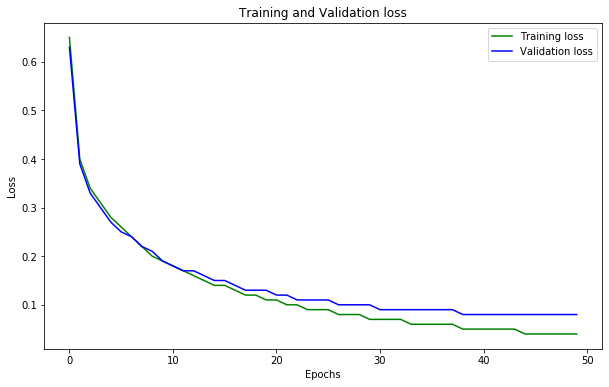

In [16]:
# Training Loss vs Validation Loss graph

plt.figure(figsize=(10,6))
plt.plot(epochs_list, train_loss_list, 'g', label='Training loss')
plt.plot(epochs_list, test_loss_list, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

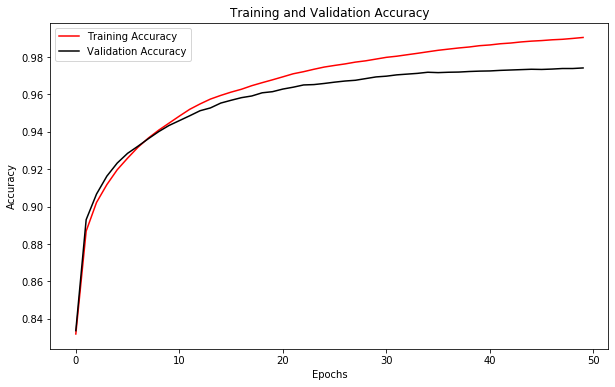

In [17]:
# Training Accuracy vs Validation Accuracy graph

plt.figure(figsize=(10,6))
plt.plot(epochs_list, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs_list, test_accuracy, 'k', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()